<a href="https://colab.research.google.com/github/amylynnn/weatherwise-Amylynn-Sophie/blob/main/DRAFT%204%20Untitled22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🔐 Enter your OpenWeatherMap API Key: 7cf20335110caaf78db0fecb31852d45

☁️  Welcome to the Weather Assistant!  ☁️

🌈 What would you like to do?
A. Ask Weather Question
B. Visualize Temperature
C. Visualize Precipitation
D. Exit
c
📍 Enter city for precipitation chart: new york


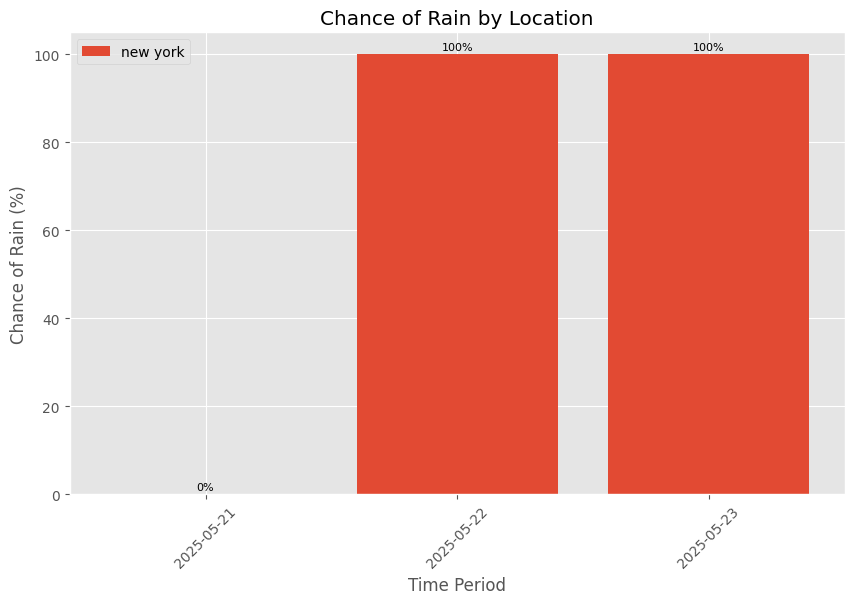


🌈 What would you like to do?
A. Ask Weather Question
B. Visualize Temperature
C. Visualize Precipitation
D. Exit


In [ ]:
# ✅ Install required packages
!pip install -q requests pandas matplotlib plotly pyinputplus

# ✅ Imports
import os
import re
import requests
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import pyinputplus as pyip
from typing import Union, List, Dict

# ✅ Set OpenWeatherMap API key
os.environ['OPENWEATHER_API_KEY'] = input("🔐 Enter your OpenWeatherMap API Key: ")

# ✅ Fetch Weather Data
def get_weather_data(location: Union[str, List[str]], forecast_days: int = 3) -> Dict[str, dict]:
    if isinstance(location, str):
        location = [location]
    results = {}
    api_key = os.environ.get('OPENWEATHER_API_KEY')
    for loc in location:
        try:
            url = f"http://api.openweathermap.org/data/2.5/forecast?q={loc}&appid={api_key}&units=metric"
            res = requests.get(url)
            if res.status_code != 200:
                raise ValueError(f"{res.status_code} - {res.text}")
            raw = res.json()
            forecast = {}
            for entry in raw["list"]:
                date = entry["dt_txt"].split()[0]
                if date not in forecast:
                    forecast[date] = {
                        "temperature": entry["main"]["temp"],
                        "rain": "rain" in entry.get("weather", [{}])[0]["description"].lower(),
                        "humidity": entry["main"]["humidity"],
                        "wind": entry["wind"]["speed"]
                    }
                    if len(forecast) >= forecast_days:
                        break
            results[loc] = {
                "current_conditions": raw["list"][0]["main"],
                "forecast": forecast
            }
        except Exception as e:
            results[loc] = {"error": f"❌ Failed to retrieve weather for {loc}: {e}"}
    return results

# ✅ Parse Natural Language Question
def parse_weather_question(question):
    question = question.lower()
    loc_match = re.search(r'in ([a-zA-Z ]+)', question)
    location = loc_match.group(1).title().strip() if loc_match else 'your area'
    if 'tomorrow' in question:
        time = 'tomorrow'
    elif 'weekend' in question:
        time = 'this weekend'
    else:
        time = list(get_weather_data(location).get(location, {}).get("forecast", {}).keys())[0]
    for attr in ['temperature', 'rain', 'snow', 'wind', 'humidity']:
        if attr in question:
            attribute = attr
            break
    else:
        attribute = 'temperature'
    return {'location': location, 'time_period': time, 'attribute': attribute}

# ✅ Convert Units and Generate Responses
def convert_temperature(value, unit='Celsius'):
    if unit == "Fahrenheit":
        return round((value * 9/5) + 32)
    return round(value)

def convert_wind_speed(value, unit='km/h'):
    if unit == "mph":
        return round(value / 1.609)
    return round(value)

def generate_weather_response(parsed, data, temp_unit='Celsius', wind_unit='km/h'):
    loc = parsed['location']
    time = parsed['time_period']
    attr = parsed['attribute']
    if loc not in data or time not in data[loc]:
        return f"❌ No forecast available for {loc} {time}."
    forecast = data[loc][time]
    def convert_temp(c): return f"{convert_temperature(c, temp_unit)}°{'F' if temp_unit == 'Fahrenheit' else 'C'}"
    def convert_wind(w): return f"{convert_wind_speed(w, wind_unit)} {wind_unit}"
    responses = {
        'temperature': lambda: f"🌡️ Temperature in {loc} {time} is {convert_temp(forecast.get('temperature', 0))}.",
        'rain': lambda: f"🌧️ Expect {'rain' if forecast.get('rain') else 'no rain'} in {loc} {time}.",
        'snow': lambda: f"❄️ Snow forecast not available, assuming none in {loc} {time}.",
        'wind': lambda: f"💨 Wind speed in {loc} {time} is {convert_wind(forecast.get('wind', 0))}.",
        'humidity': lambda: f"💧 Humidity in {loc} {time} is {forecast.get('humidity', 'unknown')}%."
    }
    return responses.get(attr, lambda: "Invalid attribute")()

# ✅ Interactive Temperature Line Chart (Plotly)
def create_temperature_visualisation_interactive(weather_data):
    rows = []
    for location, times_data in weather_data.items():
        for time, info in times_data.items():
            rows.append({"Location": location, "Time": time, "Temperature": info["temperature"]})
    df = pd.DataFrame(rows)
    fig = px.line(df, x="Time", y="Temperature", color="Location", markers=True,
                  title="Interactive Temperature Forecast")
    fig.update_traces(hovertemplate="%{y}°C at %{x}<br>%{fullData.name}")
    fig.update_layout(xaxis_tickangle=-45)
    fig.show()

# ✅ Grouped Precipitation Chart (Matplotlib)
def create_precipitation_visualisation_from_df(df: pd.DataFrame, output_type='display'):
    plt.style.use('ggplot')  # ✅ Built-in style compatible with Colab
    fig, ax = plt.subplots(figsize=(10, 6))
    locations = df['Location'].unique()
    time_labels = df['Time'].unique()
    width = 0.8 / len(locations)
    x = range(len(time_labels))
    for idx, loc in enumerate(locations):
        loc_data = df[df['Location'] == loc]
        loc_data = loc_data.set_index('Time').reindex(time_labels).reset_index()
        offsets = [i + (idx * width) for i in x]
        precip = loc_data['Precipitation'].fillna(0).tolist()
        ax.bar(offsets, precip, width=width, label=loc)
        for i, value in enumerate(precip):
            ax.text(offsets[i], value + 1, f"{value}%", ha='center', fontsize=8)
    ax.set(title="Chance of Rain by Location", xlabel="Time Period", ylabel="Chance of Rain (%)")
    ax.set_xticks([i + width * (len(locations)-1)/2 for i in x])
    ax.set_xticklabels(time_labels, rotation=45)
    ax.legend()
    ax.grid(True)
    if output_type == 'figure':
        return fig
    plt.show()

# ✅ Text-Based Menu System
def print_banner():
    print("\n" + "="*40)
    print("☁️  Welcome to the Weather Assistant!  ☁️")
    print("="*40)

def main_menu():
    return pyip.inputMenu(
        ["Ask Weather Question", "Visualize Temperature", "Visualize Precipitation", "Exit"],
        lettered=True,
        numbered=False,
        prompt="\n🌈 What would you like to do?\n"
    )

# ✅ Run Interface
def run_interface():
    print_banner()
    while True:
        choice = main_menu()
        if "Ask" in choice:
            user_question = input("🧠 Ask a weather question (e.g., Will it rain in Paris tomorrow?): ")
            parsed = parse_weather_question(user_question)
            data = get_weather_data(parsed['location'])
            structured = {
                parsed['location']: {
                    parsed['time_period']: data.get(parsed['location'], {}).get('forecast', {}).get(parsed['time_period'], {})
                }
            }
            print(generate_weather_response(parsed, structured))
        elif "Temperature" in choice:
            city = input("📍 Enter city for temperature chart: ")
            data = get_weather_data(city)
            if 'error' in data.get(city, {}):
                print(data[city]['error'])
            else:
                create_temperature_visualisation_interactive({city: data[city]["forecast"]})
        elif "Precipitation" in choice:
            city = input("📍 Enter city for precipitation chart: ")
            data = get_weather_data(city)
            forecast = data.get(city, {}).get("forecast", {})
            if not forecast:
                print(f"❌ No data available for {city}.")
                continue
            # Convert forecast to DataFrame
            rows = []
            for date, info in forecast.items():
                rows.append({
                    "Location": city,
                    "Time": date,
                    "Precipitation": info.get("rain", 0) * 100  # Convert boolean to %
                })
            df = pd.DataFrame(rows)
            create_precipitation_visualisation_from_df(df)
        elif "Exit" in choice:
            print("👋 Goodbye!")
            break

# ▶️ Start the interface
run_interface()
